In [1]:
import math
import os
import re
from typing import Union
from collections import defaultdict

import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from tqdm import tqdm 

import MSDiversity as msd

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

# Helper Functions

In [3]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [4]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [5]:
import time
from typing import Union, List

In [6]:
def subsampling(spatial_data:Union[ad.AnnData,pd.DataFrame], 
                library_key:str, 
                library_id:str, 
                num_squares:Union[int,float], 
                spatial_key:Union[str,List[str]]):
    """
    This function generates a list of patches from a spatial data object.
    
    Parameters:
    spatial_data: anndata.AnnData or pandas.DataFrame
        The spatial data from which to generate patches.
    scaling_factor: int or float
        The scaling factor to determine the size of the patches.
    spatial_key: str or list
        The key or list of keys to access the spatial data.
        
    Returns:
    list
        A list of patches.
    """
    
    if isinstance(spatial_data, ad.AnnData):
        spatial_data_filtered = spatial_data[spatial_data.obs[library_key] == library_id]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_data_filtered = spatial_data[spatial_data[library_key] == library_id]
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")
    
    # check if spatial_data is an AnnData object or a DataFrame, and get spatial coordinates
    if isinstance(spatial_data, ad.AnnData):
        spatial_values = spatial_data_filtered.obsm[spatial_key]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_values = spatial_data_filtered[spatial_key].values
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")

        
    width = spatial_values.max(axis=0)[0] - spatial_values.min(axis=0)[0]
    height = spatial_values.max(axis=0)[1] - spatial_values.min(axis=0)[1]
    
    # Define the size of each patch
    patch_width = width / num_squares[0]
    patch_height = height / num_squares[1]
    
    # Create a list to store the patch coordinates
    patches = []

    for y0 in np.arange(spatial_values.min(axis=0)[1], spatial_values.max(axis=0)[1], patch_height):
        for x0 in np.arange(spatial_values.min(axis=0)[0], spatial_values.max(axis=0)[0], patch_width):
            # Define the coordinates of the current patch
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            # Add the current patch to the list
            patches.append((x0, y0, x1, y1))
    return patches

In [7]:
def subsampling_randomly(spatial_data: Union[ad.AnnData, pd.DataFrame], 
                         library_key:str, 
                         library_id:str, 
                         sample_size:Union[int,float], 
                         sample_number:int,
                         spatial_key:Union[str,List[str]], 
                         max_overlap=0.0, 
                         random_seed=None, 
                         min_points=2):
    
    rng = np.random.default_rng(random_seed)

    if isinstance(spatial_data, ad.AnnData):
        spatial_data_filtered = spatial_data[spatial_data.obs[library_key] == library_id]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_data_filtered = spatial_data[spatial_data[library_key] == library_id]
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")
    
    if isinstance(spatial_data, ad.AnnData):
        spatial_values = spatial_data_filtered.obsm[spatial_key]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_values = spatial_data_filtered[spatial_key].values
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")

    width = spatial_values.max(axis=0)[0] - spatial_values.min(axis=0)[0]
    height = spatial_values.max(axis=0)[1] - spatial_values.min(axis=0)[1]

    patch_width = sample_size[0]
    patch_height = sample_size[1] if sample_size[1] else sample_size[0]

    num_patches = sample_number

    patches = []
    used_coordinates = set()
    
    for _ in range(num_patches):
        start_time = time.time()
        while True:
            if time.time() - start_time > 5:  # seconds
                print(f"Warning: Could not generate a new patch within 5 seconds. Return {len(patches)} out of {num_patches} patches")
                return patches
            
            x0 = rng.uniform(spatial_values.min(axis=0)[0], spatial_values.max(axis=0)[0] - patch_width)
            y0 = rng.uniform(spatial_values.min(axis=0)[1], spatial_values.max(axis=0)[1] - patch_height)
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            new_patch = (x0, y0, x1, y1)
            if ((x0, y0) not in used_coordinates and 
                msd.overlap_check(new_patch, patches, max_overlap) and 
                msd.contains_points(new_patch, spatial_values, min_points)  ):
                used_coordinates.add((x0, y0))
                patches.append(new_patch)
                break

    return patches

# Read Data

In [8]:
data_dir = '/Users/Emrys/Dropbox/spatial_augmentation/data/cosMx_liver/data/'
results_dir = './results_crc'

# Load data
# combine data os path
liver_df = pd.read_csv(os.path.join(data_dir, 'cosMx_liver_meta.csv')) # ~793318 cells
liver_df.columns

Index(['RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident',
       'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes',
       'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio',
       'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18',
       'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45',
       'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name',
       'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow',
       'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px',
       'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity',
       'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts',
       'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex',
       'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9',
       'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell',
       'nFeaturePerCell', 'propNe

In [9]:
liver_df = liver_df[['cell_ID', 'Run_Tissue_name', 'x_slide_mm', 'y_slide_mm', 'fov', 'nCell', 'cellType', 'niche']].copy()
liver_df['x_slide_um'] = (liver_df['x_slide_mm']*1000.0).round(0)
liver_df['y_slide_um'] = (liver_df['y_slide_mm']*1000.0).round(0)
liver_df

,cell_ID,Run_Tissue_name,x_slide_mm,y_slide_mm,fov,nCell,cellType,niche,x_slide_um,y_slide_um
0,c_1_100_10,NormalLiver,9.03144,9.73500,100,1265,Hep.3,Zone_3a,9031.0,9735.0
1,c_1_100_1078,NormalLiver,8.77440,9.25824,100,1265,Hep.4,Zone_2a,8774.0,9258.0
2,c_1_100_1135,NormalLiver,8.87928,9.23412,100,1265,Inflammatory.macrophages,Zone_2a,8879.0,9234.0
3,c_1_100_267,NormalLiver,9.12132,9.61104,100,1265,Hep.5,Zone_2a,9121.0,9611.0
4,c_1_100_732,NormalLiver,9.08436,9.40548,100,1265,Central.venous.LSECs,Zone_2a,9084.0,9405.0
...,...,...,...,...,...,...,...,...,...,...
793313,c_2_9_945,CancerousLiver,5.44420,11.27840,9,949,Inflammatory.macrophages,tumor,5444.0,11278.0
793314,c_2_9_947,CancerousLiver,5.45332,11.27804,9,949,Non.inflammatory.macrophages,tumor,5453.0,11278.0
793315,c_2_9_948,CancerousLiver,5.32684,11.27792,9,949,tumor_1,tumor,5327.0,11278.0
793316,c_2_9_949,CancerousLiver,5.29252,11.27732,9,949,tumor_1,tumor,5293.0,11277.0


# Subsampling

In [10]:
liver_df.loc[:, 'sample'] = '-1'  # Initialize the 'patches' column with -1 
patches_coord_dict = {}
for tissue_type in pd.unique(liver_df['Run_Tissue_name']):
    print(f"Processing {tissue_type}", flush=True)
    # patches_coord = subsampling(liver_df,
    #                             'Run_Tissue_name',
    #                             tissue_type,
    #                             num_squares=[11.0,8.0], 
    #                             spatial_key=['x_slide_um', 'y_slide_um'])

    patches_coord = subsampling_randomly(spatial_data=liver_df, 
                                         library_key='Run_Tissue_name', 
                                         library_id=tissue_type, 
                                         sample_size=[1600,1600],
                                         sample_number=10,
                                         spatial_key=['x_slide_um', 'y_slide_um'], 
                                         max_overlap=0.0, 
                                         random_seed=42, 
                                         min_points=12000)    
    
    patches_coord_dict[tissue_type] = patches_coord
    print(f"Total number of patches: {len(patches_coord)}",flush=True)
    print(patches_coord)
    # Iterate over patches
    for i, patch in enumerate(patches_coord):
        x0, y0, x1, y1 = patch
        
        # Define the number of decimal places for rounding
        decimal_places = 5
        
        # When assigning patch coordinates
        x0 = round(x0, decimal_places)
        y0 = round(y0, decimal_places)
        x1 = round(x1, decimal_places)
        y1 =round(y1, decimal_places)
    
        # Update the 'patches' column for cells within the current patch
        if tissue_type == 'NormalLiver':
            sample_name = 'N'+str(i)
        else:
            sample_name = 'C'+str(i)
            
        liver_df.loc[
            (liver_df['Run_Tissue_name'] == tissue_type) &
            (liver_df['x_slide_um'] >= x0) & 
            (liver_df['x_slide_um'] <= x1) & 
            (liver_df['y_slide_um'] >= y0) & 
            (liver_df['y_slide_um'] <= y1), 
            'sample'
        ] = sample_name
        # print(liver_df.loc[
        #     (liver_df['Run_Tissue_name'] == tissue_type) &
        #     (liver_df['x_slide_mm'] >= x0) & 
        #     (liver_df['x_slide_mm'] <= x1) & 
        #     (liver_df['y_slide_mm'] >= y0) & 
        #     (liver_df['y_slide_mm'] <= y1), 
        #     'patches'
        # ].shape[0])


# liver_df.drop(liver_df[ (liver_df['sample'] == '-1')].index, inplace=True)


Processing NormalLiver
Total number of patches: 10
[(1886.6148806917008, 10025.667690297836, 3486.614880691701, 11625.667690297836), (7967.310663046048, 8786.71629929017, 9567.310663046048, 10386.71629929017), (2196.0119891029517, 6592.722490085427, 3796.0119891029517, 8192.722490085427), (4408.565586928444, 9706.33596711446, 6008.565586928444, 11306.33596711446), (5070.607250708777, 5134.232285585302, 6670.607250708777, 6734.232285585302), (2302.5292319298533, 4397.568560631123, 3902.5292319298533, 5997.568560631123), (7121.82980264373, 6728.084803351514, 8721.82980264373, 8328.084803351514), (2416.6294404359564, 8200.149971508083, 4016.6294404359564, 9800.149971508083), (9767.184347122256, 6801.335263858796, 11367.184347122256, 8401.335263858797), (4050.9145487720484, 7052.114822553971, 5650.914548772049, 8652.114822553971)]
Processing CancerousLiver
Total number of patches: 10
[(8733.940845498759, 6956.522134005294, 10333.940845498759, 8556.522134005294), (959.7836280173957, 9924.93

# Determine P-value cutoff

0.000 per cent patches are empty


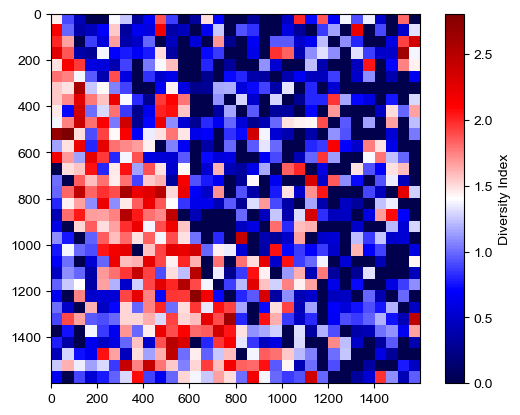

In [25]:
test_sample = 'C7'
cluster_key = 'cellType' 
patches_coordinates = msd.generate_patches(liver_df,
                                           'sample',
                                           test_sample,
                                           scaling_factor=32.,
                                           spatial_key=['x_slide_um', 'y_slide_um'])

patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=liver_df, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key=['x_slide_um', 'y_slide_um'], 
                                                            patches=patches_coordinates, 
                                                            cluster_key=cluster_key, 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=liver_df,
                                          library_key='sample', 
                                          library_id=test_sample,
                                          spatial_key=['x_slide_um', 'y_slide_um'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [12]:
from pysal.lib import weights
from pysal.explore import esda
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FuncFormatter)

In [26]:
n, m = grid.shape
w = weights.lat2W(n, m, rook=False)
lisa = esda.Moran_Local(grid.flatten(), w, transformation='r', permutations=999, seed=42) 

In [27]:
lisa.p_sim

array([0.447, 0.266, 0.065, ..., 0.064, 0.225, 0.194])

In [28]:
lisa.sim.shape

(999, 1024)

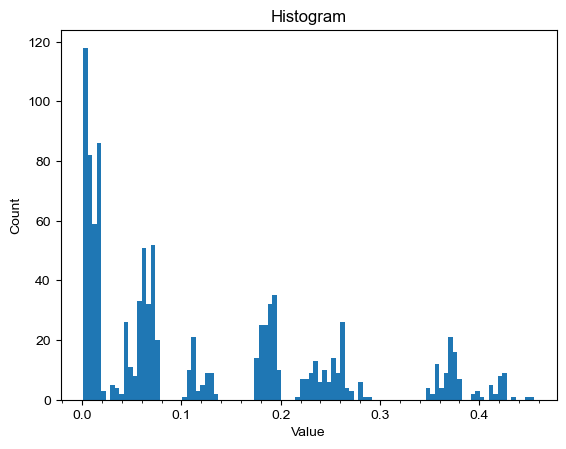

In [29]:
plt.hist(lisa.p_sim, bins=100)  # You can adjust the number of bins
 
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

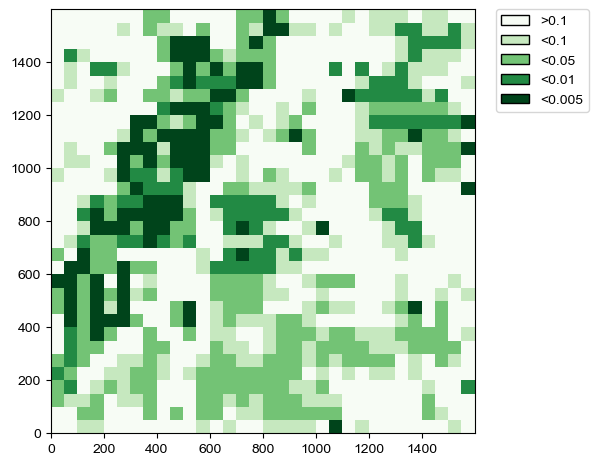

In [30]:
heatmap_fig = msd.pvalue_heatmap(spatial_data=liver_df,
                                 library_key='sample', 
                                 library_id=test_sample,
                                 spatial_key=['x_slide_um', 'y_slide_um'],
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=pd.Series(lisa.p_sim),
                                 tissue_only=False,
                                 plot=True,
                                 discrete=True,
                                 return_fig=True)
heatmap_fig.tight_layout()
ax = heatmap_fig.gca()  # Get the current Axes
ax.invert_yaxis()
save_path = '../figures/liver/liver_'+ test_sample + '_lisa_sigmap.svg'
heatmap_fig.savefig(save_path)

In [31]:
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
 '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', 
 '#000000']
print(len(bokai_palette))
print(len(pd.unique(liver_df['cellType'])))
bokai_palette1 = dict(zip(pd.unique(liver_df['cellType']), bokai_palette))
bokai_palette1 = {key: bokai_palette1[key] for key in sorted(bokai_palette1)}
bokai_palette2 = dict(zip(pd.unique(liver_df['niche']), bokai_palette))

22
22


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_91913/1104162498.py:9: UserWarning: The palette list has more values (22) than needed (18), which may not be intended.
  sns.scatterplot(data=liver_subsample,


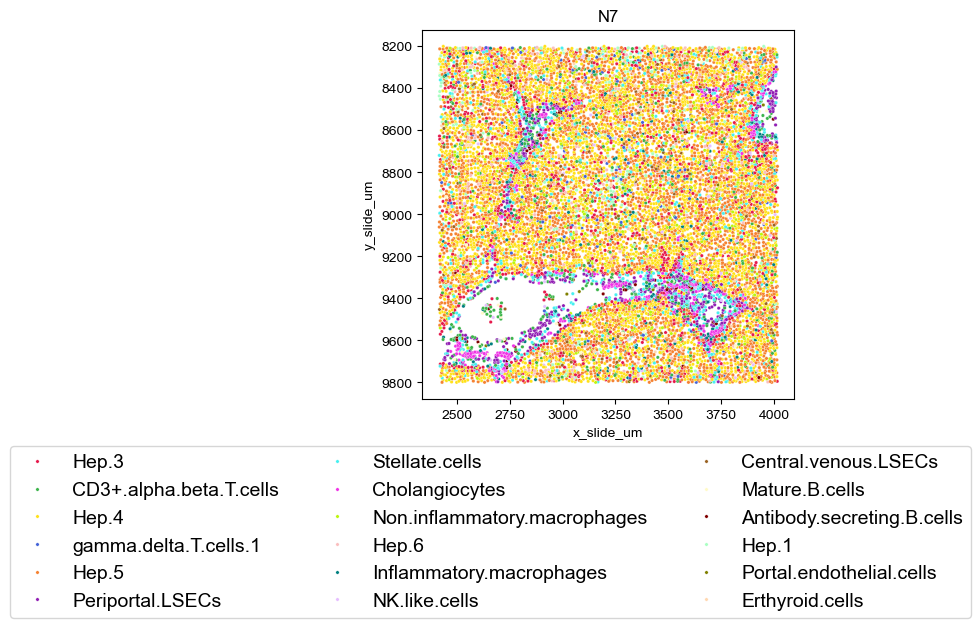

In [22]:
liver_subsample = liver_df.loc[liver_df['sample'] == test_sample,:]
x_coords = liver_subsample['x_slide_um']
y_coords = liver_subsample['y_slide_um']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=liver_subsample, 
                x="x_slide_um", y="y_slide_um", 
                hue="cellType", palette=bokai_palette, s=6, 
                legend='full', ax=ax, rasterized=True)
ax.set_title(test_sample)
ax.legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize=14)
ax.invert_yaxis()
save_path = test_sample + '_celltype.svg'
fig.savefig('../figures/liver/'+save_path, dpi=300)
plt.show()